In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
plt.style.use('ggplot')

In [5]:
cuisines_df = pd.read_csv('data/Cuisines.csv', header = None)
cuisines_df = cuisines_df.rename(columns = {1: 'cuisine_label'})
recipes_df = pd.read_csv('data/recipes.csv')
display(cuisines_df.head(2))
display(recipes_df.head(2))

,0,cuisine_label
0,1,Chinese
1,2,English


,'acorn squash',adobo,'african birdseye chile pepper',ale,'aleppo pepper','alfalfa sprouts','alfredo sauce',allspice,almond,'almond butter',...,yeast,'yellow curry paste','yellow food coloring','yellow split pea','yellow squash',yogurt,zaatar,zest,zucchini,cuisine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
recipes_df.shape

(4236, 710)

# PCA

In [29]:
X = recipes_df.drop('cuisine', axis=1) 
y = pd.DataFrame(recipes_df.cuisine)
y.set_index(X.index, inplace=True)

In [30]:
from sklearn.decomposition import PCA
# pca = PCA(n_components = 12)
pca = PCA().fit(X)

cum_expl_var = []
for i in range(len(pca.explained_variance_)):
    if i == 0:
        cum_expl_var.append(pca.explained_variance_[i])
    else:
        cum_expl_var.append(pca.explained_variance_[i] + cum_expl_var[i-1])
        
cum_expl_var_ratio_pca = np.cumsum(pca.explained_variance_ratio_)

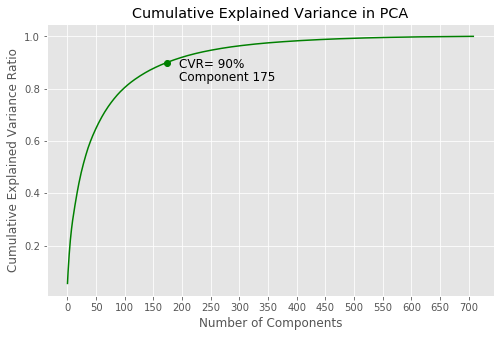

In [31]:
cum_90 = np.where(cum_expl_var_ratio_pca >= 0.9)[0][0]

plt.figure(figsize=[8,5])
plt.style.use('ggplot')
plt.plot(cum_expl_var_ratio_pca, color="green")
plt.plot(cum_90, 0.9,'go') 
plt.title('Cumulative Explained Variance in PCA')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xticks(np.arange(0, len(pca.components_), 50))
plt.annotate("CVR= 90%", (cum_90+20, 0.88)).set_fontsize(12)
plt.annotate("Component {}".format(cum_90+1), (cum_90+20, 0.83)).set_fontsize(12)
# plt.savefig('../figures/1-4.png', bbox_inches = 'tight', pad_inches = 0)

In [32]:
X_pca = PCA(n_components=175).fit_transform(X)

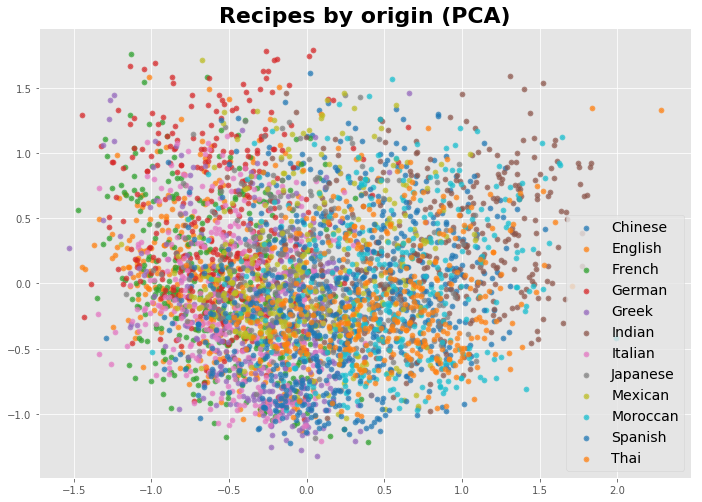

In [33]:
palette = sns.color_palette("tab10", n_colors = 12)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipes by origin (PCA)", size=22, fontweight="bold")
for i, cur_origin in enumerate(np.unique(y)):
    plot = plt.scatter(X_pca[(y == cur_origin)['cuisine'], 1], X_pca[(y == cur_origin)['cuisine'], 2], 
                c = palette[i], label = cur_origin, s = 5, linewidth=3.5, alpha=0.7)
    plot.set_label(cuisines_df.cuisine_label[i])

plt.legend(fontsize=14, loc='best')
plt.show()
#plt.savefig("pca.png")

# Create train and test set

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.33, random_state=0)

# K-Means without PCA

In [74]:
def kmeans_grid_search(ks, X_train, y_train):
    accs = []
    for k in tqdm(ks):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
        accs.append(accuracy_score(y_train, kmeans.predict(X_train))*100)
    return accs

def plot_accs(ks, accs): 
    fig, ax = plt.subplots(figsize=(8,6))
    plt.plot(ks, accs, color='green', linewidth=2.5)
    plt.title('Accuracy for different values of k',fontsize=15, fontweight="bold")
    plt.xticks(ks)
    plt.xlabel('Number of components ($k$)', fontsize = 14)
    plt.ylabel('Accuracy (%)', fontsize = 14)

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from tqdm import tqdm

ks = np.linspace(12, 500, 20, dtype=np.int64)
accs = kmeans_grid_search(ks, X_train, y_train)

100%|██████████| 20/20 [07:00<00:00, 21.01s/it]


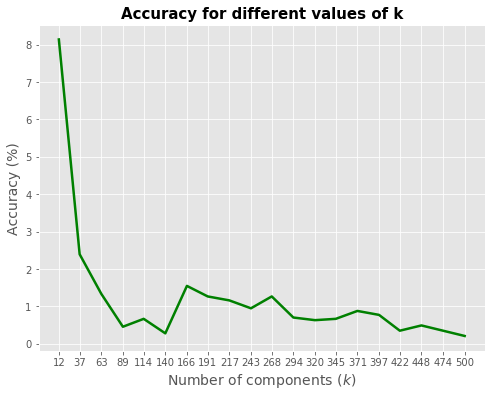

In [75]:
plot_accs(ks, accs)

#### Testing accuracy for best k

In [78]:
best_k = ks[accs == max(accs)][0]
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(X_train)
accuracy_score(y_test, kmeans.predict(X_test))*100

8.226037195994278

# K-Means with PCA

In [76]:
ks_pca = np.linspace(12, 175, 20, dtype=np.int64)
accs_pca = kmeans_grid_search(ks, X_train_pca, y_train_pca)

100%|██████████| 20/20 [02:04<00:00,  6.22s/it]


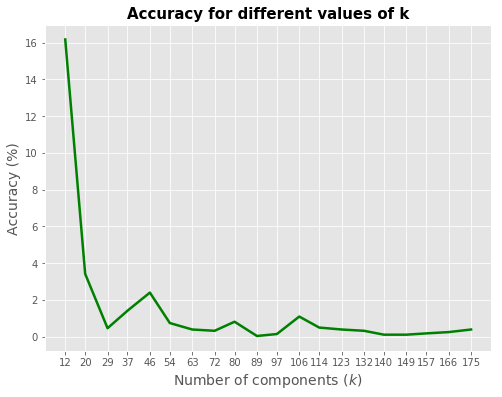

In [77]:
plot_accs(ks_pca, accs_pca)

In [79]:
best_k_pca = ks_pca[accs_pca == max(accs_pca)][0]
kmeans = KMeans(n_clusters=best_k_pca, random_state=0).fit(X_train_pca)
accuracy_score(y_test_pca, kmeans.predict(X_test_pca))*100

15.52217453505007